In [22]:
!pip install keras tensorflow numpy protobuf

In [2]:
%%bash
# 扱うデータのダウンロード
wget https://storage.googleapis.com/170804handson/catsanddogs/data.tar.gz
tar xvzf data.tar.gz
echo Done!!

data/
data/train/
data/train/cats/
data/train/cats/cat0406.jpg
data/train/cats/cat0653.jpg
data/train/cats/cat0607.jpg
data/train/cats/cat0117.jpg
data/train/cats/cat0781.jpg
data/train/cats/cat0066.jpg
data/train/cats/cat0557.jpg
data/train/cats/cat0775.jpg
data/train/cats/cat0042.jpg
data/train/cats/cat0422.jpg
data/train/cats/cat0914.jpg
data/train/cats/cat0799.jpg
data/train/cats/cat0725.jpg
data/train/cats/cat0644.jpg
data/train/cats/cat0729.jpg
data/train/cats/cat0388.jpg
data/train/cats/cat0661.jpg
data/train/cats/cat0432.jpg
data/train/cats/cat0106.jpg
data/train/cats/cat0348.jpg
data/train/cats/cat0225.jpg
data/train/cats/cat0221.jpg
data/train/cats/cat0241.jpg
data/train/cats/cat0120.jpg
data/train/cats/cat0655.jpg
data/train/cats/cat0338.jpg
data/train/cats/cat0948.jpg
data/train/cats/cat0171.jpg
data/train/cats/cat0734.jpg
data/train/cats/cat0926.jpg
data/train/cats/cat0939.jpg
data/train/cats/cat0214.jpg
data/train/cats/cat0033.jpg
data/train/cats/cat0013.jpg
data/train/ca

--2017-08-04 09:30:52--  https://storage.googleapis.com/170804handson/catsanddogs/data.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.25.112, 2404:6800:4004:819::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.25.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62712702 (60M) [application/x-tar]
Saving to: ‘data.tar.gz’

     0K .......... .......... .......... .......... ..........  0% 3.87M 15s
    50K .......... .......... .......... .......... ..........  0% 10.9M 10s
   100K .......... .......... .......... .......... ..........  0% 2.74M 14s
   150K .......... .......... .......... .......... ..........  0% 14.5M 12s
   200K .......... .......... .......... .......... ..........  0% 6.67M 11s
   250K .......... .......... .......... .......... ..........  0% 20.6M 10s
   300K .......... .......... .......... .......... ..........  0% 5.48M 10s
   350K .......... .......... .......... .......... .

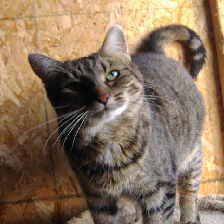

In [15]:
"""データを見てみる
"""

import re
from urllib.request import urlopen
from PIL import Image
from io import BytesIO

def load_img(path, target_size=None):
    """pythonで画像を読み込むメソッド。ローカルのパスかURLから読める仕組みにしている。
    """
    if re.match("^(http|https):", path):
        data = urlopen(path).read()
        image = Image.open(BytesIO(data)).convert('RGB')
    else:
        image = Image.open(path).convert('RGB')

    if target_size:
        return image.resize(target_size)
    else:
        return image
    
target_path = './data/train/cats/cat0021.jpg'
img = load_img(target_path, target_size=(224, 224))
img

### VGG16とは
- ImageNet（1400万枚の画像）を学習させた1000クラス分類器
- お金と知恵のある人達が公開している学習済みのCNNのモデル
![vgg16](https://www.cs.toronto.edu/~frossard/post/vgg16/vgg16.png)

In [13]:
"""まずは普通にVGGの出力を見てみる
"""
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.models import Model

base_model = VGG16(include_top=True, weights='imagenet')
vgg_model = Model(inputs=base_model.inputs, outputs=base_model.get_layer('fc2').output)

In [16]:
import numpy as np
from keras.preprocessing.image  import img_to_array

def detect_labels(image_path):
    # Top-5のクラスを予測
    # VGG16の1000クラス分類結果がdecode_predictions()で文字列に変換される
    x = load_img(image_path, target_size=(224, 224))
    x = np.expand_dims(x, axis=0).astype('float64')
    preds = base_model.predict(preprocess_input(x))
    return decode_predictions(preds, top=5)

detect_labels(target_path)

40960/35363 [==================================] - 0s 


[[('n02123045', 'tabby', 0.52955508),
  ('n02123159', 'tiger_cat', 0.28029695),
  ('n02124075', 'Egyptian_cat', 0.14918479),
  ('n03223299', 'doormat', 0.008056866),
  ('n04040759', 'radiator', 0.0028970768)]]

In [17]:
from keras.preprocessing.image import list_pictures
import pandas as pd

"""画像テーブルを作成。まずは画像ファイルのパスのカラムだけ
pythonのpandasというLibraryのDataFrameという構造体なので、慣習的にdfという変数名にします
"""
df = pd.DataFrame(list_pictures('data/validation'), columns=['file_path'])
df.head()

,file_path
0,data/validation/dogs/dog0194.jpg
1,data/validation/dogs/dog0050.jpg
2,data/validation/dogs/dog0099.jpg
3,data/validation/dogs/dog0327.jpg
4,data/validation/dogs/dog0143.jpg


In [18]:
def img_to_vec(file_path):
    """今までの一連をメソッド化したもの。画像をvectorに変換する
    """
    img = load_img(file_path, target_size=(224, 224))
    img = np.expand_dims(img_to_array(img), axis=0)
    return vgg_model.predict(preprocess_input(img)).flatten().tolist()

In [19]:
%%time

"""画像テーブルにVectorカラムを追加し、画像をベクトル化して詰めていく
800枚なので4分くらいかかる
"""

df = df.assign(
    vec=lambda df: df.file_path.apply(img_to_vec)
)
df.head()

CPU times: user 25min 11s, sys: 1min 38s, total: 26min 50s
Wall time: 14min 30s


In [20]:
from sklearn.metrics.pairwise import cosine_similarity

def sim(target_vector, top_n=10):
    all_vector = np.array(df.vec.values.tolist())
    similarities = cosine_similarity(target_vector, all_vector).flatten()  # 　引数のVectorとテーブルのVectorの類似度を全計算
    sim_indices = similarities.argsort()[::-1]                                         #  indexを降順ソート
    return [(i, similarities[i]) for i in sim_indices][0:top_n]                 #  上位nだけslice

In [21]:
target_vec = img_to_vec(target_path)
similarities = sim(target_vec)
similarities

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[(667, 0.71375130412605525),
 (621, 0.71313598662061239),
 (472, 0.70800922929915688),
 (696, 0.70729776471889338),
 (563, 0.70538704954521292),
 (625, 0.70528177046287699),
 (545, 0.70452420995716947),
 (560, 0.70190473431523537),
 (747, 0.69962040983115104),
 (486, 0.69703247497810983)]

0.713751304126 data/validation/cats/cat0395.jpg
['tabby', 'tiger_cat', 'Egyptian_cat', 'lynx', 'carton']


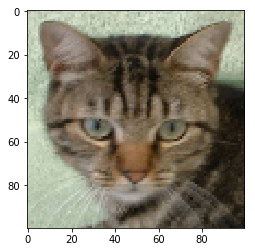

0.713135986621 data/validation/cats/cat0224.jpg
['Egyptian_cat', 'tabby', 'tiger_cat', 'lynx', 'remote_control']


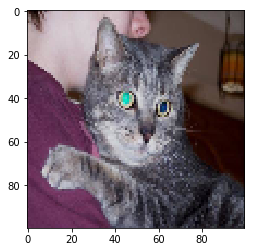

0.708009229299 data/validation/cats/cat0109.jpg
['tabby', 'tiger_cat', 'lynx', 'Egyptian_cat', 'wok']


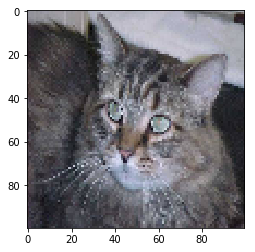

0.707297764719 data/validation/cats/cat0356.jpg
['tabby', 'tiger_cat', 'Egyptian_cat', 'lynx', 'Persian_cat']


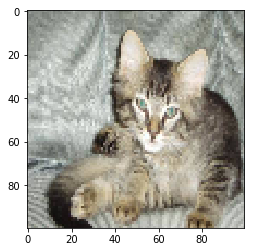

0.705387049545 data/validation/cats/cat0298.jpg
['tabby', 'tiger_cat', 'Egyptian_cat', 'carton', 'paper_towel']


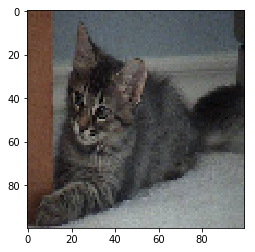

0.705281770463 data/validation/cats/cat0126.jpg
['tabby', 'tiger_cat', 'Egyptian_cat', 'radiator', 'doormat']


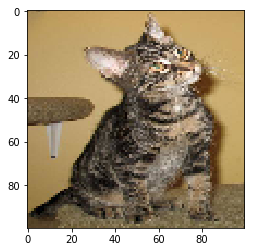

0.704524209957 data/validation/cats/cat0295.jpg
['tabby', 'tiger_cat', 'Egyptian_cat', 'Persian_cat', 'washbasin']


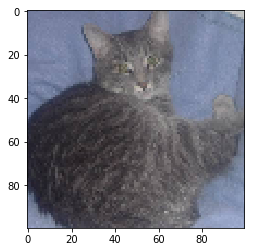

0.701904734315 data/validation/cats/cat0352.jpg
['tabby', 'tiger_cat', 'Egyptian_cat', 'lynx', 'carton']


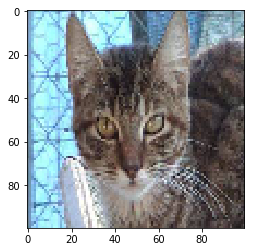

0.699620409831 data/validation/cats/cat0129.jpg
['tabby', 'tiger_cat', 'Egyptian_cat', 'carton', 'space_heater']


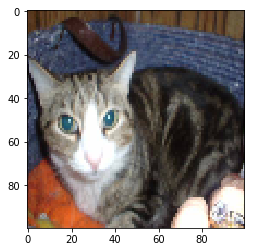

0.697032474978 data/validation/cats/cat0047.jpg
['tabby', 'tiger_cat', 'Egyptian_cat', 'lynx', 'window_screen']


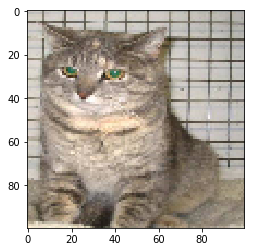

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

for i, score in similarities:
    image_path = df.ix[i].file_path
    print(score, image_path)
    print([label for (id, label, score) in detect_labels(image_path)[0]])
    image = load_img(image_path, target_size=(100, 100))
    plt.imshow(np.array(image))
    plt.show()